In [ ]:
import os
import pickle
import random
import itertools
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import networkx as nx
from networkx.algorithms import isomorphism
import matplotlib.pyplot as plt
import math
import numpy as np

# ----------------------------------------
# 0) Hyper-parameters & Globals
# ----------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_NODES           = 4
EDGES               = [(i, j) for i in range(NUM_NODES) for j in range(i+1, NUM_NODES)]
NUM_EDGES           = len(EDGES)
NUM_PARETO_SAMPLES  = 20

FINAL_TRAIN_EPOCHS  = 10

# MODNAS/Hypernet/Supernet/Architect parameters
NUM_EPOCHS          = 50
INITIAL_TAU         = 5.0
FINAL_TAU           = 0.5
NUM_RAYS            = 60
SAMPLES_PER_R       = 100

# EA parameters
pop_size            = 20      
num_gens            = 50      

CACHE_PATH          = f'canonical_nodes{NUM_NODES}_edges{NUM_EDGES}.pkl'

# ----------------------------------------
# 1) Define NB201-style OPS (no inplace ReLU!)
# ----------------------------------------
def op_zeroize():     return None
def op_skip():        return nn.Identity()
def op_conv1x1():     return nn.Sequential(
                            nn.ReLU(),
                            nn.Conv2d(16,16,1,padding=0, bias=False),
                            nn.BatchNorm2d(16))
def op_conv3x3():     return nn.Sequential(
                            nn.ReLU(),
                            nn.Conv2d(16,16,3,padding=1, bias=False),
                            nn.BatchNorm2d(16))
def op_avgpool3x3():  return nn.AvgPool2d(3, stride=1, padding=1)

OPS    = [op_zeroize, op_skip, op_conv1x1, op_conv3x3, op_avgpool3x3]
NUM_OPS = len(OPS)

# ----------------------------------------
# 2) Enumerate & prune DAGs w/ isomorphism
# ----------------------------------------
if os.path.exists(CACHE_PATH):
    with open(CACHE_PATH, 'rb') as f:
        CANONICAL_ARCHS = pickle.load(f)
    print(f"Loaded {len(CANONICAL_ARCHS)} architectures from cache.")
else:
    CANONICAL_ARCHS, REPS = [], []
    for sel in itertools.product(range(NUM_OPS), repeat=NUM_EDGES):
        G = nx.DiGraph()
        G.add_nodes_from(range(NUM_NODES))
        for (i,j),op_idx in zip(EDGES, sel):
            if op_idx != 0:
                G.add_edge(i, j, op=op_idx)
        # connectivity check
        if any(not (nx.has_path(G,0,n) and nx.has_path(G,n,NUM_NODES-1))
               for n in range(1,NUM_NODES-1)):
            continue
        # isomorphism check
        if any(
            isomorphism.DiGraphMatcher(G,H,
              edge_match=lambda e1,e2: e1['op']==e2['op']
            ).is_isomorphic()
            for H,_ in REPS
        ):
            continue
        REPS.append((G,sel))
        CANONICAL_ARCHS.append(sel)
    with open(CACHE_PATH,'wb') as f:
        pickle.dump(CANONICAL_ARCHS,f)
    print(f"Pruned to {len(CANONICAL_ARCHS)} architectures and cached.")

N_ARCHS = len(CANONICAL_ARCHS)

# ----------------------------------------
# 3) Size metric
# ----------------------------------------
SIZE_LIST = []
for op_fn in OPS:
    m = op_fn()
    SIZE_LIST.append(0 if m is None else sum(p.numel() for p in m.parameters()))
ARCH_SIZES    = torch.tensor([sum(SIZE_LIST[o] for o in sel)
                              for sel in CANONICAL_ARCHS],
                              dtype=torch.float, device=device)
MAX_ARCH_SIZE = ARCH_SIZES.max()

# ----------------------------------------
# 4) Hypernetwork & Gumbel-ST (with annealing)
# ----------------------------------------
class HyperNet(nn.Module):
    def __init__(self, hidden=512):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden)
        self.fc2 = nn.Linear(hidden, N_ARCHS)
    def forward(self, r):
        return self.fc2(F.relu(self.fc1(r)))

class Architect:
    def __init__(self, tau, eps=1e-8):
        self.tau, self.eps = tau, eps
    def sample(self, logits):
        g     = -torch.log(-torch.log(torch.rand_like(logits)+self.eps)+self.eps)
        z     = (logits + g) / self.tau
        y_soft= F.softmax(z, dim=-1)
        idx   = y_soft.argmax().item()
        y_hard= torch.zeros_like(y_soft); y_hard[idx]=1
        return (y_hard - y_soft).detach() + y_soft, idx

# ----------------------------------------
# 5) One-shot SuperNet with GlobalAvgPool
# ----------------------------------------
class SuperNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_proj = nn.Conv2d(3,16,1,bias=False)
        self.edge_ops   = nn.ModuleList([
            nn.ModuleList([op_fn() for op_fn in OPS])
            for _ in range(NUM_EDGES)
        ])
        self.classifier = nn.Linear(16*NUM_NODES,10)

    def forward(self, arch_idx, x):
        feat = {0: self.input_proj(x)}
        for n in range(1, NUM_NODES):
            feat[n] = torch.zeros_like(feat[0])
        sel = CANONICAL_ARCHS[arch_idx]
        for e,(i,j) in enumerate(EDGES):
            op_idx = sel[e]
            m      = self.edge_ops[e][op_idx]
            if m is None: continue
            out = m(feat[i])
            c   = out.shape[1]
            if c < 16:
                pad = torch.zeros_like(out[:,:16-c])
                pad = pad.view(out.size(0),16-c,out.size(2),out.size(3))
                out = torch.cat([out,pad],dim=1)
            feat[j] = feat[j] + out
        allf = torch.cat([feat[n] for n in range(NUM_NODES)],dim=1)
        gap  = allf.mean(dim=[2,3])
        return self.classifier(gap)

# ----------------------------------------
# 6) Data Loaders
# ----------------------------------------
transform     = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,)*3,(0.5,)*3)
                ])
train_ds      = torchvision.datasets.CIFAR10('./data',True,transform,download=True)
val_ds        = torchvision.datasets.CIFAR10('./data',False,transform,download=True)
train_loader  = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=4)
val_loader    = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=4)

# ----------------------------------------
# 7) Instantiate & Optimizers
# ----------------------------------------
hypernet  = HyperNet().to(device)
supernet  = SuperNet().to(device)
architect = Architect(tau=INITIAL_TAU)
opt_w     = torch.optim.SGD(supernet.parameters(), lr=0.01, momentum=0.9)
opt_phi   = torch.optim.Adam(hypernet.parameters(),    lr=1e-3)

# ----------------------------------------
# 8) Bi-level Training w/ MGDA‐style aggregation
# ----------------------------------------
thetas   = np.linspace(1e-3, math.pi/2-1e-3, NUM_RAYS)
rays     = [torch.tensor([math.cos(t), math.sin(t)],device=device)
            for t in thetas]

for ep in tqdm(range(NUM_EPOCHS), desc="Epochs"):
    # 1) Anneal τ
    architect.tau = INITIAL_TAU + (FINAL_TAU-INITIAL_TAU)*(ep/(NUM_EPOCHS-1))

    # 8.a) SuperNet update
    supernet.train()
    for x, y in tqdm(train_loader, desc="  SuperNet batches", leave=False):
        x, y = x.to(device), y.to(device)
        idx  = random.randrange(N_ARCHS)
        loss = F.cross_entropy(supernet(idx, x), y)
        opt_w.zero_grad(); loss.backward(); opt_w.step()

    # 8.b) HyperNet MGDA‐style update
    hypernet.train()
    # collect and sum per-ray grads
    sum_grads = [torch.zeros_like(p) for p in hypernet.parameters()]
    val_iter  = iter(val_loader)
    for r in tqdm(rays, desc="  HyperNet rays", leave=False):
        try:
            xv, yv = next(val_iter)
        except StopIteration:
            val_iter = iter(val_loader)
            xv, yv   = next(val_iter)
        xv, yv = xv.to(device), yv.to(device)

        opt_phi.zero_grad()
        logits      = hypernet(r)
        y_soft, idx = architect.sample(logits)
        loss_v      = F.cross_entropy(supernet(idx, xv), yv).detach()
        size_norm   = (y_soft @ ARCH_SIZES) / MAX_ARCH_SIZE
        obj         = r[0]*loss_v + r[1]*size_norm
        obj.backward()
        # accumulate
        for g_idx, p in enumerate(hypernet.parameters()):
            sum_grads[g_idx] += p.grad.detach()

    # now average & step
    for p, g in zip(hypernet.parameters(), sum_grads):
        p.grad = g / len(rays)
    opt_phi.step()

# ----------------------------------------
# 8.5) One‐shot evaluator (unchanged)
# ----------------------------------------
def evaluate_proxy(idxs):
    Rs      = [(ARCH_SIZES[i]/MAX_ARCH_SIZE).item() for i in idxs]
    correct = {i:0 for i in idxs}
    total   = len(val_ds)
    supernet.eval()
    with torch.no_grad():
        for x,y in val_loader:
            x, y = x.to(device), y.to(device)
            for idx in idxs:
                correct[idx] += (supernet(idx,x).argmax(1)==y).sum().item()
    Accs = [correct[i]/total for i in idxs]
    return list(zip(idxs, Rs, Accs))

def dominates(a,b):
    return (a[0]<=b[0] and a[1]>=b[1]) and (a[0]<b[0] or a[1]>b[1])

def nondom_front(points):
    return [p for p in points if not any(dominates(q,p) for q in points if q!=p)]

# ----------------------------------------
# 9.a) Random Search
# ----------------------------------------
rand_inds = random.sample(range(N_ARCHS), NUM_PARETO_SAMPLES)

# ----------------------------------------
# 9.b) ModNAS sweep w/ local search
# ----------------------------------------
mod_cands     = []
val_iter      = iter(val_loader)
for r in tqdm(rays, desc="ModNAS rays"):
    # fetch one small val batch for cheap proxy in local search
    try:
        xv, yv = next(val_iter)
    except StopIteration:
        val_iter = iter(val_loader)
        xv, yv   = next(val_iter)
    xv, yv = xv.to(device), yv.to(device)

    logits = hypernet(r)
    local  = []
    for _ in range(SAMPLES_PER_R):
        _, idx    = architect.sample(logits)
        best_idx  = idx
        # 2.i) one-step random neighborhood search
        for _ in range(5):
            sel = list(CANONICAL_ARCHS[best_idx])
            e   = random.randrange(NUM_EDGES)
            choices = [o for o in range(NUM_OPS) if o!=sel[e]]
            sel[e]   = random.choice(choices)
            tpl      = tuple(sel)
            if tpl in CANONICAL_ARCHS:
                new_idx = CANONICAL_ARCHS.index(tpl)
                # cheap proxy objective
                lv0 = F.cross_entropy(supernet(best_idx,xv), yv).item()
                lv1 = F.cross_entropy(supernet(new_idx, xv), yv).item()
                s0  = (ARCH_SIZES[best_idx]/MAX_ARCH_SIZE).item()
                s1  = (ARCH_SIZES[new_idx]/MAX_ARCH_SIZE).item()
                if r[0]*lv1 + r[1]*s1 < r[0]*lv0 + r[1]*s0:
                    best_idx = new_idx
        local.append(best_idx)
    mod_cands.extend(local)

# dedupe & Pareto‐filter
mod_cands    = list(dict.fromkeys(mod_cands))
cand_metrics = evaluate_proxy(mod_cands)

# corrected nondominated filtering
mod_inds = []
for idx_i, size_i, acc_i in cand_metrics:
    dominated = False
    for idx_j, size_j, acc_j in cand_metrics:
        if idx_j == idx_i:
            continue
        # does j dominate i?
        if (size_j <= size_i and acc_j >= acc_i) and (size_j < size_i or acc_j > acc_i):
            dominated = True
            break
    if not dominated:
        mod_inds.append(idx_i)

# then pick the smallest-size ones
mod_inds = sorted(mod_inds, key=lambda i: ARCH_SIZES[i].item())[:NUM_PARETO_SAMPLES]


# ----------------------------------------
# 9.c) NSGA-II w/ archive & normalized crowding-distance
# ----------------------------------------
def crowding_distance(front):
    idxs, sizes, accs = zip(*front)
    # normalize each objective
    s_min, s_max = min(sizes), max(sizes)
    a_min, a_max = min(accs),  max(accs)
    norm = lambda v, lo, hi: (v-lo)/(hi-lo+1e-12)
    sn = [norm(s,s_min,s_max) for s in sizes]
    an = [norm(a,a_min,a_max) for a in accs]

    dist = {idx:0.0 for idx in idxs}
    # infinite at ends
    os = sorted(zip(idxs, sn), key=lambda x:x[1])
    oa = sorted(zip(idxs, an), key=lambda x:x[1])
    dist[os[0][0]] = dist[os[-1][0]] = float('inf')
    dist[oa[0][0]] = dist[oa[-1][0]] = float('inf')
    # accumulate
    for i in range(1,len(idxs)-1):
        dist[os[i][0]] += os[i+1][1] - os[i-1][1]
        dist[oa[i][0]] += oa[i+1][1] - oa[i-1][1]
    return dist

archive = []
pop     = random.sample(range(N_ARCHS), pop_size)
for gen in tqdm(range(num_gens), desc="NSGA-II gens"):
    # mutation-only offspring
    offspring = []
    for pid in pop:
        sel = list(CANONICAL_ARCHS[pid])
        e   = random.randrange(NUM_EDGES)
        choices = [o for o in range(NUM_OPS) if o!=sel[e]]
        sel[e] = random.choice(choices)
        tpl    = tuple(sel)
        if tpl in CANONICAL_ARCHS:
            offspring.append(CANONICAL_ARCHS.index(tpl))
    combined = pop + offspring

    ev    = evaluate_proxy(combined)
    front = [(i,s,a) for i,(s,a) in zip(combined, [(s,a) for _,s,a in ev])
             if not any((s2<=s and a2>=a and (s2<s or a2>a))
                        for _,s2,a2 in ev if _!=i)]

    # update archive (elitism)
    archive += [i for i,_,_ in front]
    archive  = list({*archive})
    arch_ev  = evaluate_proxy(archive)
    archive  = [i for i,_,_ in nondom_front(arch_ev)]

    # refill population: half from archive, half by crowding
    half = pop_size//2
    pop  = random.sample(archive, min(len(archive), half)) + \
           [i for i,_ in sorted(
                crowding_distance(front).items(),
                key=lambda x:x[1], reverse=True
            )[:pop_size-half]]
nsga_inds = pop[:NUM_PARETO_SAMPLES]


Loaded 8680 architectures from cache.


Epochs:   4%|▍         | 2/50 [00:03<01:11,  1.49s/it]

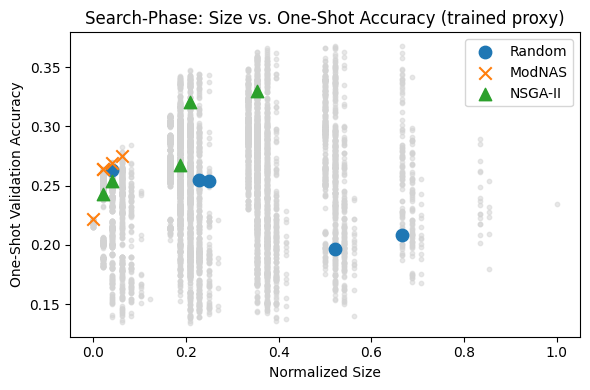

In [ ]:
# 10) One‐shot: compute size & acc for every arch exactly once  
one_shot_table = {}  # idx -> (size_norm, one_shot_acc)
supernet.eval()
with torch.no_grad():
    # init counters
    correct = {i: 0 for i in range(N_ARCHS)}
    total   = len(val_ds)
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        # for each idx in one pass
        for idx in range(N_ARCHS):
            preds = supernet(idx, x)
            correct[idx] += (preds.argmax(1)==y).sum().item()
    # now fill table
    for idx in range(N_ARCHS):
        size_norm = (ARCH_SIZES[idx] / MAX_ARCH_SIZE).item()
        acc       = correct[idx] / total
        one_shot_table[idx] = (size_norm, acc)

# 11) Extract the full cloud and each method's picks from that table
R_all, Acc_all = zip(*one_shot_table.values())

R_rand,   Acc_rand   = zip(*(one_shot_table[i] for i in rand_inds))
R_modnas, Acc_modnas = zip(*(one_shot_table[i] for i in mod_inds))
R_nsga,   Acc_nsga   = zip(*(one_shot_table[i] for i in nsga_inds))

# 12) Plot from that single table
plt.figure(figsize=(6,4))
plt.scatter(R_all,    Acc_all,    color='lightgray', alpha=0.5, s=10, label='_nolegend_')
plt.scatter(R_rand,   Acc_rand,   marker='o', s=80, label='Random')
plt.scatter(R_modnas, Acc_modnas, marker='x', s=80, label='ModNAS')
plt.scatter(R_nsga,   Acc_nsga,   marker='^', s=80, label='NSGA-II')
plt.xlabel('Normalized Size')
plt.ylabel('One-Shot Validation Accuracy')
plt.title('Search-Phase: Size vs. One-Shot Accuracy (trained proxy)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
unique_inds = sorted(set(rand_inds + mod_inds + nsga_inds))
print("Random picks:   ", rand_inds)
print("ModNAS picks:   ", mod_inds)
print("NSGA-II picks:  ", nsga_inds)
print("Unique picks:   ", unique_inds, "→", len(unique_inds))

Random picks:    [1091, 6400, 5034, 2387, 3733]
ModNAS picks:    [789, 1865, 2233, 2767, 2927]
NSGA-II picks:   [6759, 6760, 1077, 4679, 179]
Unique picks:    [179, 789, 1077, 1091, 1865, 2233, 2387, 2767, 2927, 3733, 4679, 5034, 6400, 6759, 6760] → 15


In [ ]:
# ----------------------------------------
# 11) Fixed‐architecture network for from‐scratch training
# ----------------------------------------
class FixedNet(nn.Module):
    def __init__(self, sel):
        super().__init__()
        self.sel = sel
        # same input projection
        self.input_proj = nn.Conv2d(3, 16, kernel_size=1, bias=False)
        # one op module per edge (None for zeroize)
        self.edge_ops = nn.ModuleList([
            None if op_idx == 0 else OPS[op_idx]()
            for op_idx in sel
        ])
        # classifier after global avg‐pool
        self.classifier = nn.Linear(16 * NUM_NODES, 10, bias=True)

    def forward(self, x):
        # initialize per-node features
        feat = {0: self.input_proj(x)}
        for n in range(1, NUM_NODES):
            feat[n] = torch.zeros_like(feat[0])
        # propagate along edges
        for e, (i, j) in enumerate(EDGES):
            m = self.edge_ops[e]
            if m is None:
                continue
            out = m(feat[i])
            # zero‐pad channels if needed
            c = out.shape[1]
            if c < 16:
                pad = torch.zeros_like(out[:, :16-c, ...])
                pad = pad.view(out.size(0), 16-c, out.size(2), out.size(3))
                out = torch.cat([out, pad], dim=1)
            feat[j] = feat[j] + out
        # concat node features, global‐avg‐pool spatial dims
        allf = torch.cat([feat[n] for n in range(NUM_NODES)], dim=1)
        gap  = allf.mean(dim=[2,3])       # shape (B,16*NUM_NODES)
        return self.classifier(gap)

# ----------------------------------------
# 12) Gather the distinct indices from each method
# ----------------------------------------
methods = {
    'Random': rand_inds,
    'ModNAS': mod_inds,
    'NSGA-II': nsga_inds
}
# unique set of architectures to train
unique_inds = sorted(set(rand_inds + mod_inds + nsga_inds))

# ----------------------------------------
# 13) Train each net from scratch, evaluate on validation set
# ----------------------------------------
TRAIN_EPOCHS = FINAL_TRAIN_EPOCHS
results = {}  # idx -> test_acc

# outer loop: iterate architectures
for idx in tqdm(unique_inds, desc='Archs', unit='arch'):
    sel = CANONICAL_ARCHS[idx]
    net = FixedNet(sel).to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TRAIN_EPOCHS)

    # inner loop: train epochs with progress bar
    net.train()
    for ep in tqdm(range(TRAIN_EPOCHS), desc=f'Arch {idx}', leave=False, unit='ep'):
        epoch_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            out = net(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * y.size(0)
        scheduler.step()

    # evaluation (you can also add a small progress bar here if desired)
    net.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = net(x)
            correct += (out.argmax(1) == y).sum().item()
            total   += y.size(0)

    test_acc = correct / total
    results[idx] = test_acc
    tqdm.write(f"Arch {idx:4d} → val_acc = {test_acc:.4f}")



Archs:   7%|▋         | 1/15 [00:05<01:12,  5.15s/arch]

Arch  179 → val_acc = 0.2658


Archs:  13%|█▎        | 2/15 [00:10<01:06,  5.14s/arch]

Arch  789 → val_acc = 0.2376


Archs:  20%|██        | 3/15 [00:15<01:01,  5.15s/arch]

Arch 1077 → val_acc = 0.2544


Archs:  27%|██▋       | 4/15 [00:21<00:59,  5.38s/arch]

Arch 1091 → val_acc = 0.3409


Archs:  33%|███▎      | 5/15 [00:26<00:52,  5.28s/arch]

Arch 1865 → val_acc = 0.2790


Archs:  40%|████      | 6/15 [00:31<00:47,  5.25s/arch]

Arch 2233 → val_acc = 0.2700


Archs:  47%|████▋     | 7/15 [00:36<00:41,  5.21s/arch]

Arch 2387 → val_acc = 0.3047


Archs:  53%|█████▎    | 8/15 [00:41<00:36,  5.18s/arch]

Arch 2767 → val_acc = 0.3323


Archs:  60%|██████    | 9/15 [00:46<00:31,  5.19s/arch]

Arch 2927 → val_acc = 0.3323


Archs:  67%|██████▋   | 10/15 [00:52<00:26,  5.24s/arch]

Arch 3733 → val_acc = 0.4247


Archs:  73%|███████▎  | 11/15 [00:57<00:20,  5.20s/arch]

Arch 4679 → val_acc = 0.3207


Archs:  80%|████████  | 12/15 [01:03<00:16,  5.44s/arch]

Arch 5034 → val_acc = 0.5563


Archs:  87%|████████▋ | 13/15 [01:09<00:11,  5.59s/arch]

Arch 6400 → val_acc = 0.5345


Archs:  93%|█████████▎| 14/15 [01:14<00:05,  5.49s/arch]

Arch 6759 → val_acc = 0.3770


Archs: 100%|██████████| 15/15 [01:19<00:00,  5.33s/arch]

Arch 6760 → val_acc = 0.4240


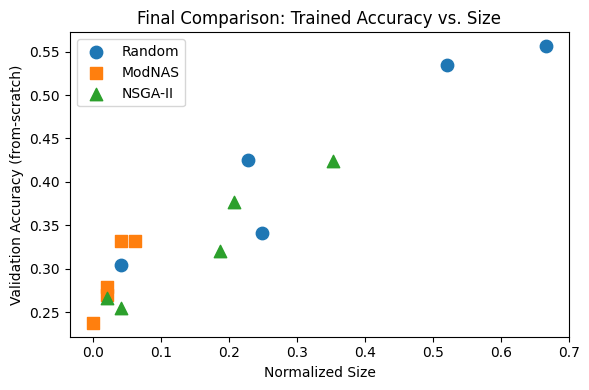

In [ ]:
# ----------------------------------------
# 14) Compare & plot final results
# ----------------------------------------
plt.figure(figsize=(6,4))
for method, inds in methods.items():
    # gather points
    xs, ys = [], []
    for idx in inds:
        xs.append((ARCH_SIZES[idx]/MAX_ARCH_SIZE).item())
        ys.append(results[idx])
    plt.scatter(xs, ys, s=80, label=method, marker={
        'Random':'o','ModNAS':'s','NSGA-II':'^'
    }[method])
plt.xlabel('Normalized Size')
plt.ylabel('Validation Accuracy (from‐scratch)')
plt.title('Final Comparison: Trained Accuracy vs. Size')
plt.legend()
plt.tight_layout()
plt.show()